# Plot GOES Data from AWS
Plot GOES TrueColor from AWS bucket

# Importing

In [1]:
# Import Modules
import requests, sys, time
import netCDF4, pytz
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import feature as cf
from cartopy.io.shapereader import Reader
import xarray
from datetime import datetime, timedelta

# Defining Parameters

In [2]:
# Satellite Parameters
satellite='noaa-goes16' # noaa-goes16 | noaa-goes17 (retired) | noaa-goes18
product='ABI-L2-MCMIP' # True color Data
scan = 'C' # CONUS

# Date Parameters
year='2018'
month='10'
day='10'
shour='16'
ehour='16'
smin='00'
emin='10'
day_of_year = datetime(int(year),int(month),int(day)).timetuple().tm_yday 

# Plotting Parameters
dpi=150
land_hex='#efefef'  # Light Gray Map (ESRI)
ocean_hex='#cfd3d4' # Light Gray Map (ESRI)
edgecolor='black'
author='Not Jared Rennie'
plt.style.use('dark_background')

# Get Data

In [3]:
#######################
# GET DATA
#######################
aws = s3fs.S3FileSystem(anon=True)
fnames = []
    
# Format date strings
if len(str(day_of_year)) == 1:
    doy = (f"00{day_of_year}")
elif len(str(day_of_year)) == 2:
    doy = (f"0{day_of_year}")
elif len(str(day_of_year)) == 3:
    doy = (f"{day_of_year}")
            
# Iterate through all desired hours to find files
for hour in range(int(shour),int(ehour)+1):
    if len(str(hour)) == 1:
        hour = (f"0{hour}")
    if len(str(hour)) == 2:
        hour = (f"{hour}")
        
    if product == "GLM-L2-LCFA": # this product only has one scan type
        data_files = aws.ls(f'{satellite}/{product}/{year}/{doy}/{hour}/', refresh=True)  
    else:
        data_files = aws.ls(f'{satellite}/{product}{scan[0]}/{year}/{doy}/{hour}/', refresh=True)  
            
    # Extracting files for chosen time
    for file in data_files:
        file_start = file.split('_')[-3][8:12]
        file_end = file.split('_')[-2][8:12]
        if ((int(file_start[0:4]) >= int((str(shour) + str(smin)))) and (int(file_end[0:4]) <= int((str(ehour) + str(emin))))):
            fnames.append(file)
    
# Disclaimer for missing product
if product == "ABI-L2-ACHT" and scan == "C": # this product only has meso scan types
        print("Cloud top temperature does not have a CONUS/PACUS scan. Please select the meso scan, or try a new product.")

# Finding the correst meso scan
if scan[0] == "M" and (product != "GLM-L2-LCFA"):
    scan_string = product[7:] + "M" + scan[1]
    fnames = [x for x in fnames if scan_string in x]
    print(f"Retrieved {len(fnames)} files from your criteria.")
else:
    print(f"Retrieved {len(fnames)} files from your criteria.")

Retrieved 2 files from your criteria.


# PLOT (CONUS)

ABI-L2-MCMIPC/2018/283/16/OR_ABI-L2-MCMIPC-M3_G16_s20182831602203_e20182831604576_c20182831605089.nc


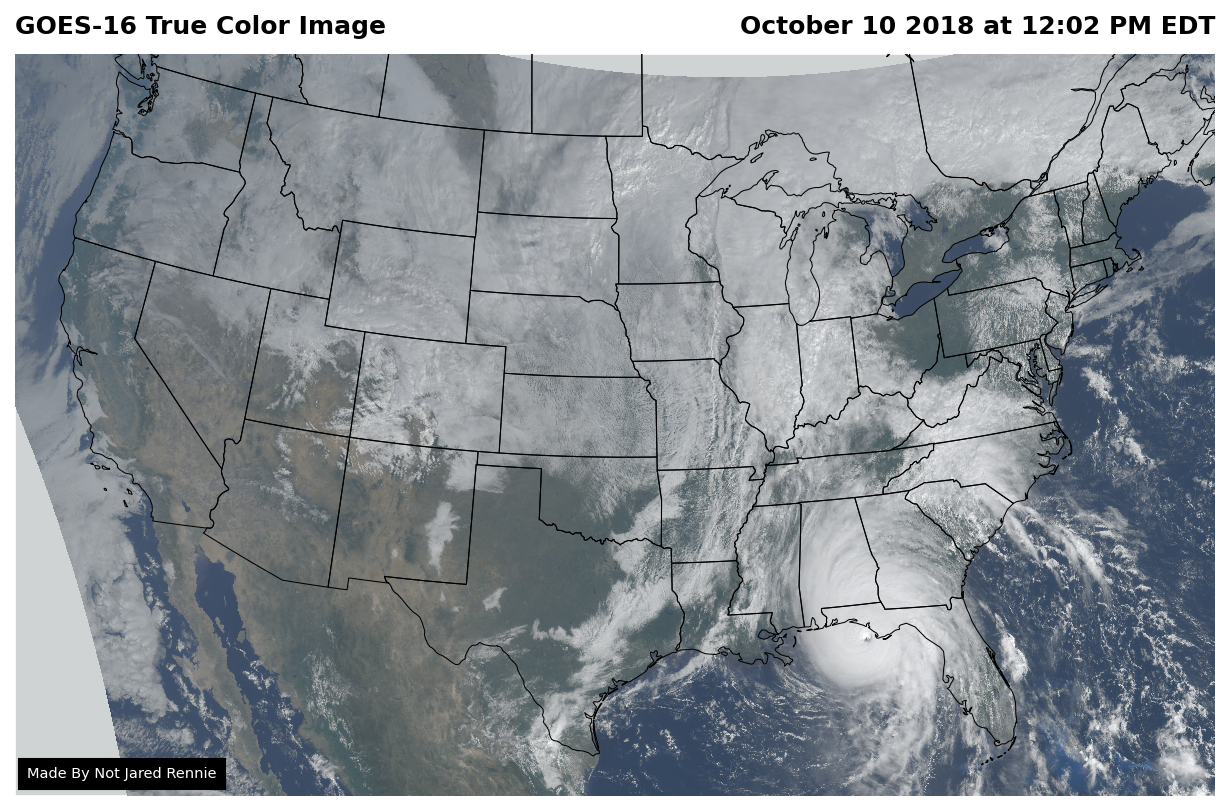

ABI-L2-MCMIPC/2018/283/16/OR_ABI-L2-MCMIPC-M3_G16_s20182831607203_e20182831609576_c20182831610086.nc


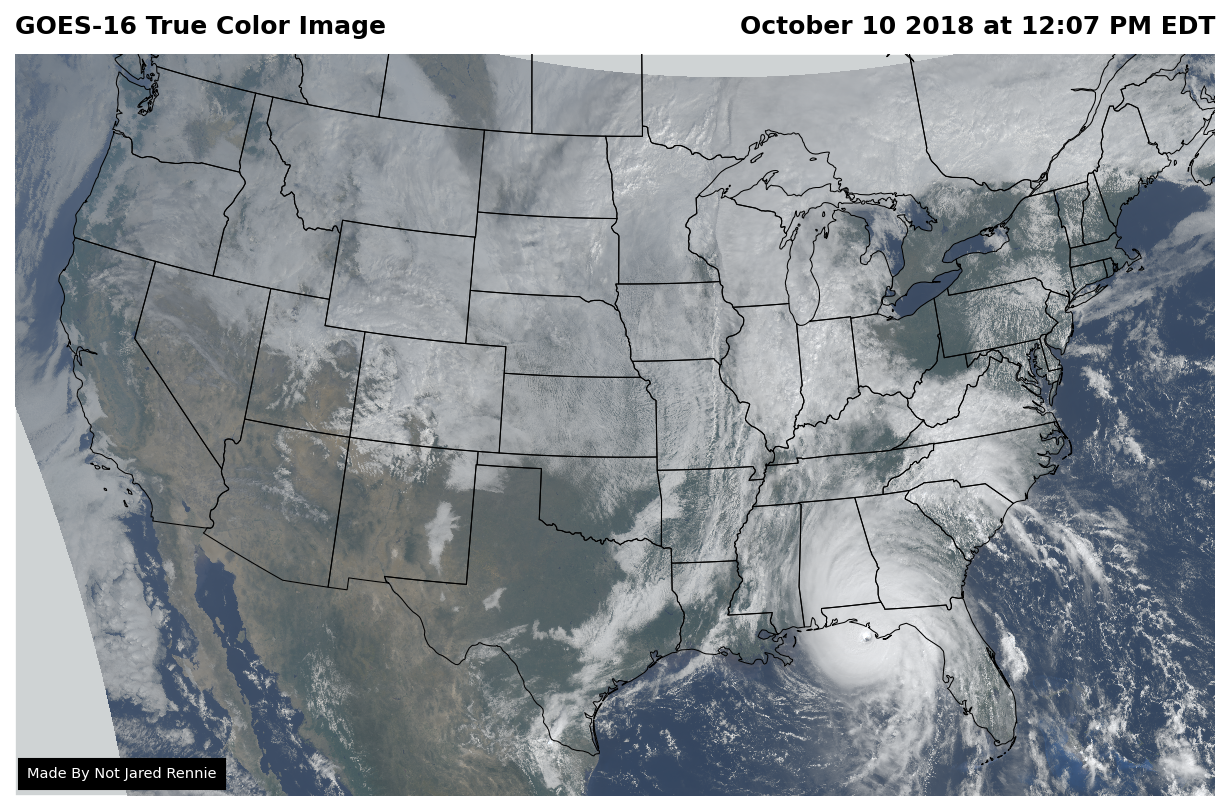

In [4]:
#######################
# PLOT (CONUS)
#######################
# CONUS Plotting Parameters
minLat = 22
maxLat = 50
minLon = -120
maxLon = -73
proj=ccrs.LambertConformal()

# Run Through Each File
for f in range(0, len(fnames)): 
    fname = (fnames[f])[12:]
    print(fname)

    # Load dataset
    resp = requests.get(f'https://{satellite}.s3.amazonaws.com/{fname}')
    nc = netCDF4.Dataset(fname, memory = resp.content)

    dataset = xarray.open_dataset(xarray.backends.NetCDF4DataStore(nc))
    dataset.load()

    # Plot True color data!
    dat = dataset.metpy.parse_cf('CMI_C02')
            
    # Create RGB dataset
    gamma = 2.2
    r = dataset['CMI_C02'].data; r = np.clip(r, 0, 1); r = np.power(r, 1/gamma)
    g = dataset['CMI_C03'].data; g = np.clip(g, 0, 1); g = np.power(g, 1/gamma)
    b = dataset['CMI_C01'].data; b = np.clip(b, 0, 1); b = np.power(b, 1/gamma)

    # Calculate the "True" Green
    g_true = 0.45 * r + 0.1 * g + 0.45 * b
    g_true = np.clip(g_true, 0, 1) 

    # Create a single RGB image for plotting
    plotting_var = np.dstack((r, g_true, b))

    # Identify plotting coordinates
    x = dat.x
    y = dat.y
    geos = dat.metpy.cartopy_crs
    nc.close()
    
    # Plotting
    fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')
    ax = fig.add_axes([0, 0, 1, 1], projection=proj)
    ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())
    ax.set_facecolor(ocean_hex)
    ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=10)
    ax.pcolormesh(x,y,plotting_var,transform=geos,zorder=9)  

    scan_start = datetime.strptime(dataset.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    outDateUTC= '{}'.format(scan_start.strftime('%B %d %Y at %H:%M UTC'))
    scan_start_lst=scan_start.astimezone(pytz.timezone('US/Eastern'))
    is_dst=scan_start_lst.dst() != timedelta(0)
    if is_dst:
        outDateLST= '{}'.format(scan_start_lst.strftime('%B %d %Y at %I:%M %p EDT'))
    else:
        outDateLST= '{}'.format(scan_start_lst.strftime('%B %d %Y at %I:%M %p EST'))
    
    # Add Title/SubTitle
    plt.title(f"GOES-{satellite[-2:]} True Color Image",size=12,color='black',y=1.01,loc='left',fontweight='bold')
    plt.title(outDateLST,size=12,color='black',y=1.01,loc='right',fontweight='bold')
    plt.annotate('Made By '+author,xy=(0.01, 0.02), xycoords='axes fraction', fontsize=7,backgroundcolor='black',color='white',horizontalalignment='left', verticalalignment='bottom',zorder=10)
    
    # Output Data 
    plt.show()
    plt.clf()
    plt.close()

# PLOT (SE Coast)

ABI-L2-MCMIPC/2018/283/16/OR_ABI-L2-MCMIPC-M3_G16_s20182831602203_e20182831604576_c20182831605089.nc


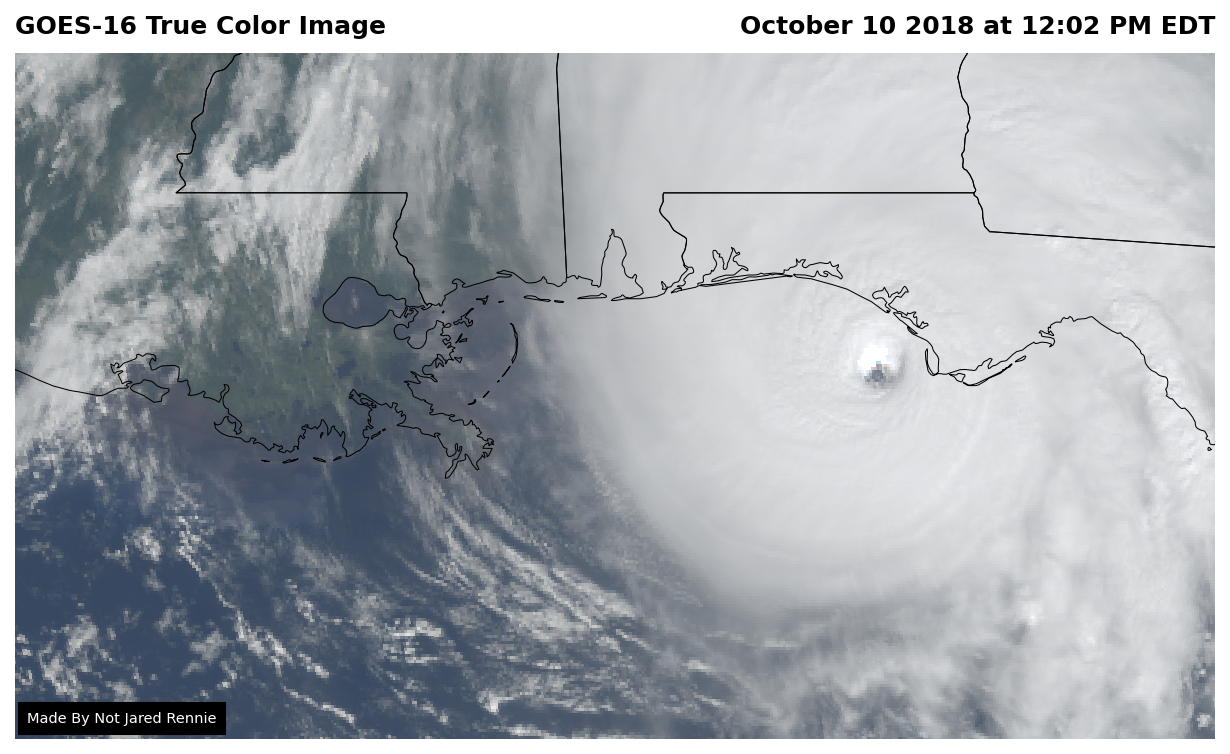

ABI-L2-MCMIPC/2018/283/16/OR_ABI-L2-MCMIPC-M3_G16_s20182831607203_e20182831609576_c20182831610086.nc


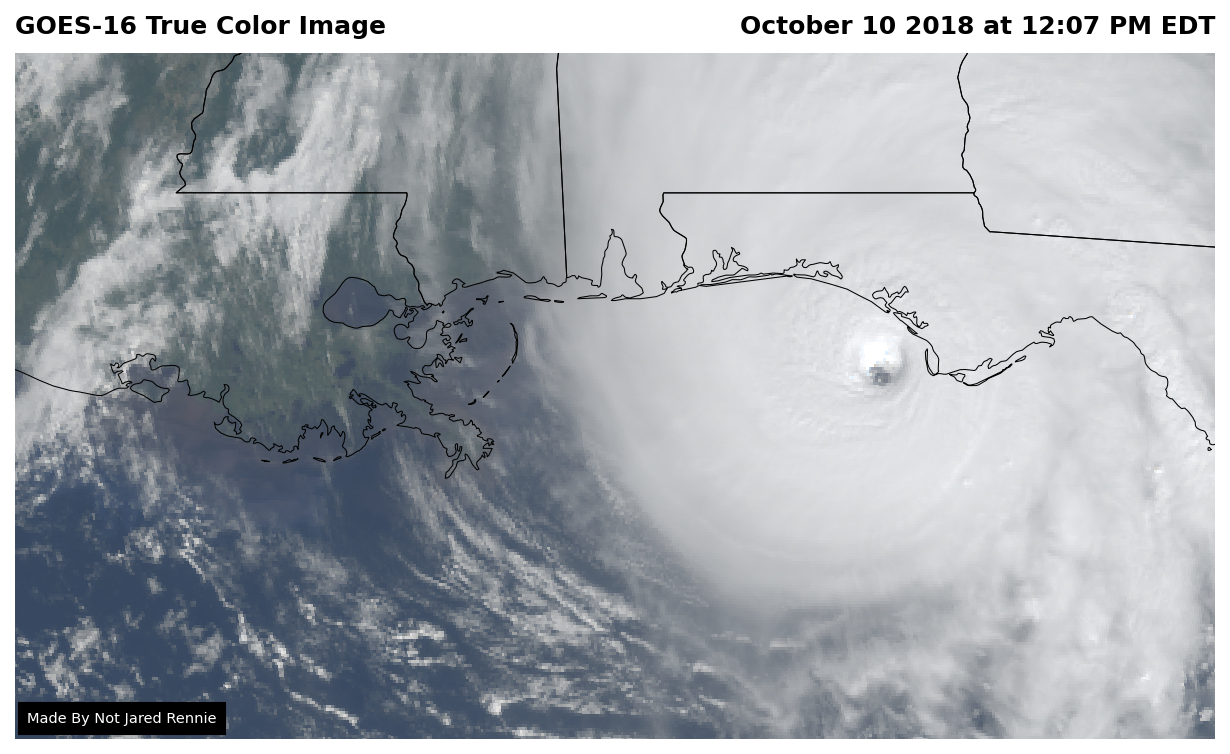

In [6]:
#######################
# PLOT (CONUS)
#######################
# CONUS Plotting Parameters
minLat = 27       
maxLat = 32  
minLon = -93 
maxLon = -83 
proj=ccrs.Mercator()

# Run Through Each File
for f in range(0, len(fnames)): 
    fname = (fnames[f])[12:]
    print(fname)

    # Load dataset
    resp = requests.get(f'https://{satellite}.s3.amazonaws.com/{fname}')
    nc = netCDF4.Dataset(fname, memory = resp.content)

    dataset = xarray.open_dataset(xarray.backends.NetCDF4DataStore(nc))
    dataset.load()

    # Plot True color data!
    dat = dataset.metpy.parse_cf('CMI_C02')
            
    # Create RGB dataset
    gamma = 2.2
    r = dataset['CMI_C02'].data; r = np.clip(r, 0, 1); r = np.power(r, 1/gamma)
    g = dataset['CMI_C03'].data; g = np.clip(g, 0, 1); g = np.power(g, 1/gamma)
    b = dataset['CMI_C01'].data; b = np.clip(b, 0, 1); b = np.power(b, 1/gamma)

    # Calculate the "True" Green
    g_true = 0.45 * r + 0.1 * g + 0.45 * b
    g_true = np.clip(g_true, 0, 1) 

    # Create a single RGB image for plotting
    plotting_var = np.dstack((r, g_true, b))

    # Identify plotting coordinates
    x = dat.x
    y = dat.y
    geos = dat.metpy.cartopy_crs
    nc.close()
    
    # Plotting
    fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')
    ax = fig.add_axes([0, 0, 1, 1], projection=proj)
    ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())
    ax.set_facecolor(ocean_hex)
    ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=10)
    ax.pcolormesh(x,y,plotting_var,transform=geos,zorder=9)  

    scan_start = datetime.strptime(dataset.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    outDateUTC= '{}'.format(scan_start.strftime('%B %d %Y at %H:%M UTC'))
    scan_start_lst=scan_start.astimezone(pytz.timezone('US/Eastern'))
    is_dst=scan_start_lst.dst() != timedelta(0)
    if is_dst:
        outDateLST= '{}'.format(scan_start_lst.strftime('%B %d %Y at %I:%M %p EDT'))
    else:
        outDateLST= '{}'.format(scan_start_lst.strftime('%B %d %Y at %I:%M %p EST'))
    
    # Add Title/SubTitle
    plt.title(f"GOES-{satellite[-2:]} True Color Image",size=12,color='black',y=1.01,loc='left',fontweight='bold')
    plt.title(outDateLST,size=12,color='black',y=1.01,loc='right',fontweight='bold')
    plt.annotate('Made By '+author,xy=(0.01, 0.02), xycoords='axes fraction', fontsize=7,backgroundcolor='black',color='white',horizontalalignment='left', verticalalignment='bottom',zorder=10)
    
    # Output Data 
    plt.show()
    plt.clf()
    plt.close()